# Vehicle Detection

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and append binned color feature and hisgram of color  to HOG feature vector.
* Train a classifier Linear SVM classifier
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run the pipeline on a video stream (full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

import utilities
import vehicleDetection

%matplotlib inline

In [33]:
# Divide up into cars and notcars
images = glob.glob('data/*/*/*.png')
vehicles = []
notvehicles = []
for image in images:
    if 'non-vehicles' in image:
        notvehicles.append(image)
    elif 'vehicles' in image:
        vehicles.append(image)
    else:
        print("error")

In [34]:
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
ORIENT = 9

# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [35]:
orient = ORIENT
pix_per_cell = PIX_PER_CELL
cell_per_block = CELL_PER_BLOCK

t=time.time()
car_features = utilities.extract_features(vehicles, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

notcar_features = utilities.extract_features(notvehicles, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

144.16 Seconds to extract HOG features...


In [36]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
np.random.seed(10)
rand_state = np.random.randint(0, 100) 
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [ ]:
from sklearn.model_selection import GridSearchCV
import pprint
# Grid Search for SVM
svc = LinearSVC()
parameters = [{
    'C' : [x/10 for x in list(range(2, 20, 2))],
    'loss': ['hinge', 'squared_hinge'],
    'penalty': ['l2']
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))

In [ ]:
svc = LinearSVC()
parameters = [{
    'C' : [x/100 for x in list(range(1, 30, 3))],
    'loss': ['hinge'],
    'penalty': ['l2']
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))

In [ ]:
svc = LinearSVC()
parameters = [{
    'C' : [x/10000 for x in list(range(1, 10, 1))],
    'loss': ['hinge'],
    'penalty': ['l2']
}]

clf = GridSearchCV(svc, parameters, cv=5, scoring='accuracy')
clf.fit(X_test, y_test)

print("best parameter:{}".format(clf.best_params_))
mean_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['mean_test_score']]
std_test_score = ["{0:.6f}".format(s) for s in clf.cv_results_['std_test_score']]
pprint.pprint(list(zip(mean_test_score, std_test_score, clf.cv_results_['params'])))

In [37]:
# Use a linear SVC
#svc = LinearSVC(C=clf.best_params_['C'], loss=clf.best_params_['loss'], penalty=clf.best_params_['penalty'])
svc = LinearSVC(C=0.0003, loss='hinge', penalty='l2')

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

9.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9916
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  0.  1.  0.  1.]
0.0029 Seconds to predict 10 labels with SVC


In [ ]:
testdata = {'Car': 'test_images/car2.png', 'Notcar': 'test_images/road.png'}

hog_imgs = []
Ych = []
for label, img in testdata.items():
    img = mpimg.imread(img)

    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    chf = feature_image[:,:,0]
    Ych.append(chf)
    feature, hog_img = utilities.get_hog_features(chf, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    
    hog_imgs.append(hog_img)
    
fontsize = 10
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6))
f.tight_layout()
ax1.imshow(mpimg.imread(testdata['Car']))
ax1.set_title('Car', fontsize=fontsize)
ax2.imshow(Ych[1])
ax2.set_title('Ch1 Feature', fontsize=fontsize)
ax3.imshow(hog_imgs[1])
ax3.set_title('Hog', fontsize=fontsize)

ax4.imshow(mpimg.imread(testdata['Notcar']))
ax4.set_title('NotCar', fontsize=fontsize)
ax5.imshow(Ych[0])
ax5.set_title('Ch1 Feature', fontsize=fontsize)
ax6.imshow(hog_imgs[0])
ax6.set_title('Hog', fontsize=fontsize)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# plt.savefig('get_hog_feature.png', bbox_inches="tight", dpi=200)

# Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

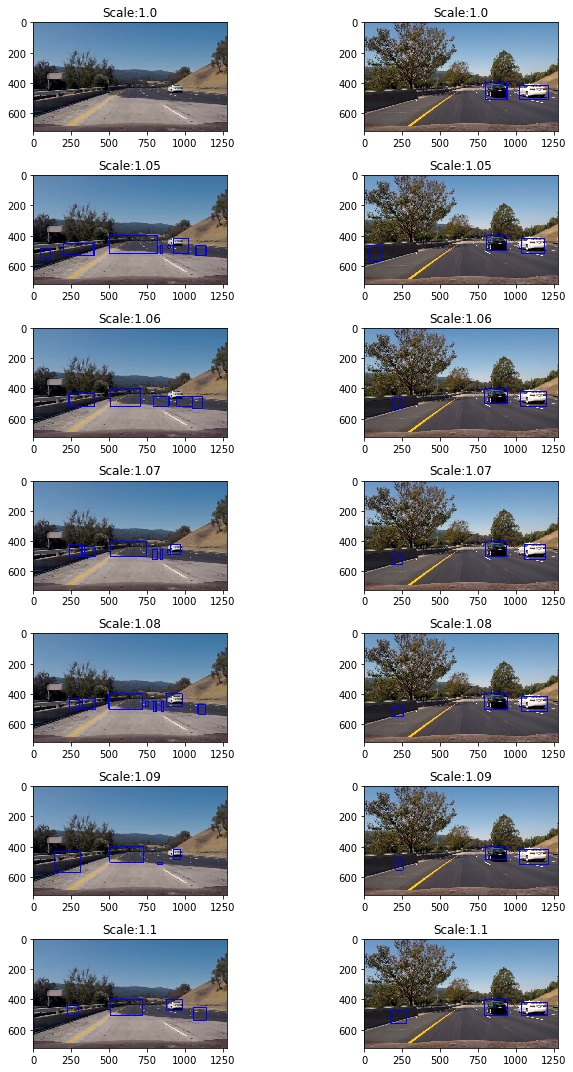

In [31]:
# Search best target image scale

CHECK_FRAME_RANGE = 5
THRESHOLD = 1

def pipe_image(image):
    return pipeline(image)

#scales = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
scales = [1.0, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1]
index = 1

plt.figure(figsize=(10, 15))

for scale in scales:
    img1 = mpimg.imread('movie2images/frame31.jpg')
    pipeline = vehicleDetection.Pipeline(svc, X_scaler, scale, CHECK_FRAME_RANGE, THRESHOLD, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)
    draw_img1 = pipe_image(img1)
    
    plt.subplot(7, 2, index)
    plt.imshow(draw_img1)
    plt.title("Scale:{}".format(scale))
    
    img2 = mpimg.imread('test_images/test6.jpg')
    pipeline = vehicleDetection.Pipeline(svc, X_scaler, scale, CHECK_FRAME_RANGE, THRESHOLD, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)
    draw_img2 = pipe_image(img2)

    plt.subplot(7, 2, index+1)
    plt.imshow(draw_img2)    
    plt.title("Scale:{}".format(scale))
    
    index = index+2

plt.tight_layout()

In [ ]:
# plot processed test images
ystart = 400
ystop = 656
scale = 1.1

img_list = glob.glob('test_images/test*.jpg')
current_bboxes = []
previouse_bboxes = []

plt.figure(figsize=(10, 15))

for index, fname in enumerate(img_list):

    img = mpimg.imread(fname)

    pipeline = vehicleDetection.Pipeline(svc, X_scaler, scale, CHECK_FRAME_RANGE, THRESHOLD, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)
    draw_img = pipe_image(img)
    
    plt.subplot(3, 2, index+1)
    plt.imshow(draw_img)
    plt.title(fname.split("/")[-1])
    
    #plt.savefig("result/test_pipeline"+fname.split('/')[-1], bbox_inches="tight", dpi=200)

plt.tight_layout()

In [ ]:
# Plot heatmap
ystart = 400
ystop = 600
scale = 1.0

img_list = glob.glob('test_images/test*.jpg')

plt.figure(figsize=(6, 18))

for index, inputimg in enumerate(img_list): 
    img = mpimg.imread(inputimg)
    car_boxes = utilities.window_search(img, ystart, ystop, scale, svc, X_scaler, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = utilities.add_heat(heat, car_boxes)

    plt.subplot(3, 2, index+1)
    plt.pcolor(heat, cmap=plt.cm.gist_heat)
    plt.title(fname.split("/")[-1])
    
plt.tight_layout()
plt.savefig("heatmaps.png", bbox_inches="tight", dpi=200)

In [28]:
import importlib
importlib.reload(utilities)
importlib.reload(vehicleDetection)

<module 'vehicleDetection' from '/Users/t.nishime/workspace/CarND-Vehicle-Detection/vehicleDetection.py'>

In [38]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [39]:
WINDOW_SCALE = 1.1
CHECK_FRAME_RANGE = 50
THRESHOLD = 1
ORIENT = 9
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2

importlib.reload(utilities)
importlib.reload(vehicleDetection)

pipeline = vehicleDetection.Pipeline(
                                     svc, 
                                     X_scaler, 
                                     WINDOW_SCALE, 
                                     CHECK_FRAME_RANGE, 
                                     THRESHOLD, 
                                     ORIENT, 
                                     PIX_PER_CELL, 
                                     CELL_PER_BLOCK)

def pipe_image(image):
    return pipeline(image)

#white_output = 'result_project_video_s11_th1_f50_600.mp4'
white_output = 'result_video224.mp4'

#clip1 = VideoFileClip('project_video.mp4')
clip1 = VideoFileClip('test_images/test_video3.mp4')
white_clip = clip1.fl_image(pipe_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video result_video224.mp4
[MoviePy] Writing video result_video224.mp4


100%|██████████| 47/47 [00:31<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_video224.mp4 

CPU times: user 50 s, sys: 1.23 s, total: 51.2 s
Wall time: 32.6 s
